<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

This part describes the implementation of the feature-finding algorithm. The core of the algorithm is described in the [MaxQuant-Paper](https://www.nature.com/articles/nbt.1511).
The supplementary material explains the underlying methodology in great detail and is the foundation of the theoretical background that is described here.
A refined version of the algorithm was presented with [Dinosaur](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4933939/), which was also used as a reference for the Python implementation.

For the algorithm, we need serval modules:

1. Connecting Centroids to Hills

2. Refinement of Hills

3. Calculating Hill Statistics

4. Combining Hills to Isotope Patterns

5. Deconvolution of Isotope Patterns

## Loading Data

From the `IO` library, we already have an `*.ms_data.hdf` container that contains centroided data. To use it in feature finding, we directly load the data.

## Connecting Centroids to Hills

:::{.callout-note}

Feature finding relies heavily on the performance function decorator from the performance notebook: `@alphapept.performance.performance_function`. Part of this is that the functions will not have return values to be GPU compatible. Please check out this notebook for further information.

:::

### Connecting centroids

Feature finding starts with connecting centroids. For this we look at subsequent scans and compare peaks that are withing a defined mass tolerance (`centroid_tol`). 

Imagine you have three scans with the following centroids:

* Scan 0: 10, 20, 30
* Scan 1: 10.2, 40.1
* Scan 2: 40, 50, 60

When comparing consecutive scans and defining the maximum delta mass to be 0.5 find the following connections: (Scan No, Centroid No) -> (Scan No, Centroid No). As we cannot easily store tuples in the matrix, we convert tuple containing the position of the connected centroid to an integer.
* (0,0) -> (1,0) -> (3): 10 & 10.2 -> delta = 0.2
* (1,1) -> (2,0) -> (6): 40.1 & 40 -> delta = 0.1

Finally, we store this in the `results` matrix:

$\begin{bmatrix}
3 & -1  & -1 \\ 
-1 & 6 & -1\\ 
-1 & -1 & -1 
\end{bmatrix}$

The coressponding `scores` matrix will look as follows:

$\begin{bmatrix}
0.2 & -1  & -1 \\ 
-1 & 0.1 & -1\\ 
-1 & -1 & -1 
\end{bmatrix}$

This allows us to not only easily store connections between centroids but also perform a quick lookup for the delta of an existing connection. Note that it also only stores the best connection for each centroid. To extract the connected centroids, we can use `np.where(results >= 0)`. This implementation allows getting millions of connections within seconds. 

As we are also allowing gaps, refering to that we can have connections between Scan 0 and Scan 2, we make the aforementioned matrix multdimensional, so that e.g. a first matrix stores the conncetions for no gap, the second matrix the connections with a gap of 1.

The functionality for this step is implemented in [`connect_centroids_unidirection`](https://mannlabs.github.io/alphapept/feature_finding.html#connect_centroids_unidirection) and the wrapper [`find_centroid_connections`](https://mannlabs.github.io/alphapept/feature_finding.html#find_centroid_connections).

In [1]:
#| echo: false
#| output: asis
show_doc(find_centroid_connections)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L66){target="_blank" style="float:right; font-size:smaller"}

### find_centroid_connections

>      find_centroid_connections (rowwise_peaks:numpy.ndarray,
>                                 row_borders:numpy.ndarray,
>                                 centroids:numpy.ndarray, max_gap:int,
>                                 centroid_tol:float)

Wrapper function to call connect_centroids_unidirection

Args:
    rowwise_peaks (np.ndarray): Length of centroids with respect to the row borders.
    row_borders (np.ndarray): Row borders of the centroids array.
    centroids (np.ndarray): Array containing the centroids data.
    max_gap (int): Maximum gap when connecting centroids.
    centroid_tol (float): Centroid tolerance.

In [2]:
#| echo: false
#| output: asis
show_doc(connect_centroids_unidirection)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L21){target="_blank" style="float:right; font-size:smaller"}

### connect_centroids_unidirection

>      connect_centroids_unidirection (x:numpy.ndarray,
>                                      row_borders:numpy.ndarray,
>                                      connections:numpy.ndarray,
>                                      scores:numpy.ndarray,
>                                      centroids:numpy.ndarray, max_gap:int,
>                                      centroid_tol:float)

Connect centroids.

Args:
    x (np.ndarray): Index to datapoint. Note that this using the performance_function, so one passes an ndarray.
    row_borders (np.ndarray): Row borders of the centroids array.
    connections (np.ndarray): Connections matrix to store the connections
    scores (np.ndarray):  Score matrix to store the connections
    centroids (np.ndarray): 1D Array containing the masses of the centroids data.
    max_gap (int): Maximum gap when connecting centroids.
    centroid_tol (float): Centroid tolerance.

We wrap the centroid connections in the function [`connect_centroids`](https://mannlabs.github.io/alphapept/feature_finding.html#connect_centroids). This function converts the connections into an usable array.

In [3]:
#| echo: false
#| output: asis
show_doc(connect_centroids)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L158){target="_blank" style="float:right; font-size:smaller"}

### connect_centroids

>      connect_centroids (rowwise_peaks:numpy.ndarray,
>                         row_borders:numpy.ndarray, centroids:numpy.ndarray,
>                         max_gap:int, centroid_tol:float)

Function to connect centroids.

Args:
    rowwise_peaks (np.ndarray): Indexes for centroids.
    row_borders (np.ndarray): Row borders (for indexing).
    centroids (np.ndarray): Centroid data.
    max_gap: Maximum gap.
    centroid_tol: Centroid tol for matching centroids.
Returns:
    np.ndarray: From index.
    np.ndarray: To index.
    float: Median score.
    float: Std deviation of the score.

In [4]:
#| echo: false
#| output: asis
show_doc(eliminate_overarching_vertex)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L144){target="_blank" style="float:right; font-size:smaller"}

### eliminate_overarching_vertex

>      eliminate_overarching_vertex (x:numpy.ndarray, from_idx:numpy.ndarray,
>                                    to_idx:numpy.ndarray)

Eliminate overacrhing vertex.

Args:
    x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    from_idx (np.ndarray): From index.
    to_idx (np.ndarray): To index.

In [5]:
#| echo: false
#| output: asis
show_doc(convert_connections_to_array)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L116){target="_blank" style="float:right; font-size:smaller"}

### convert_connections_to_array

>      convert_connections_to_array (x:numpy.ndarray, from_r:numpy.ndarray,
>                                    from_c:numpy.ndarray, to_r:numpy.ndarray,
>                                    to_c:numpy.ndarray,
>                                    row_borders:numpy.ndarray,
>                                    out_from_idx:numpy.ndarray,
>                                    out_to_idx:numpy.ndarray)

Convert integer indices of a matrix to coordinates.

Args:
    x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    from_r (np.ndarray): From array with row coordinates.
    from_c (np.ndarray): From array with column coordinates.
    to_r (np.ndarray): To array with row coordinates. 
    to_c (np.ndarray): To array with column coordinates.
    row_borders (np.ndarray): Row borders (for indexing).
    out_from_idx (np.ndarray): Reporting array: 1D index from.
    out_to_idx (np.ndarray): Reporting array: 1D index to.

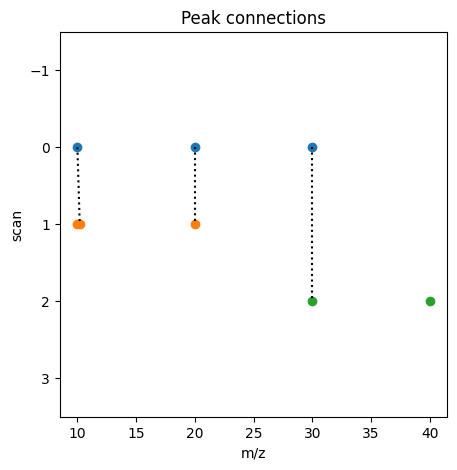

In [ ]:
#Sample snippet to show centroid conncetions

import matplotlib.pyplot as plt

row_borders = np.array([3, 6, 9])
rowwise_peaks = np.array([3, 3, 3])
max_gap = 2

score = np.full((3,3, max_gap), np.inf)
connections = np.full((3,3, max_gap), -1)

centroids = np.array([10, 20, 30, 10.2, 20, 10, 30, 40])
centroid_tol = 0.5*1e5

from_idx, to_idx, score_median, score_std = connect_centroids(rowwise_peaks, row_borders, centroids, max_gap, centroid_tol)

scan_no = np.array([0, 0, 0, 1, 1, 2, 2, 2])

plt.figure(figsize=(5,5))
for i, _ in enumerate(row_borders):
    ctrd = centroids[_-rowwise_peaks[i]:_]
    plt.plot(ctrd, np.ones_like(ctrd)*i, 'o')
    
for i, _ in enumerate(from_idx):
    from_ = _
    to_ = to_idx[i]
    plt.plot([centroids[from_], centroids[to_]], [scan_no[from_], scan_no[to_]], 'k:')
    
plt.ylabel('scan')
plt.xlabel('m/z')
plt.ylim(len(row_borders)+0.5, -1.5)
plt.title('Peak connections')
plt.show()

### Extracting hills.

To extract hills we extract connected components from the connections.

In [6]:
#| echo: false
#| output: asis
show_doc(remove_duplicate_hills)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L374){target="_blank" style="float:right; font-size:smaller"}

### remove_duplicate_hills

>      remove_duplicate_hills (hill_ptrs, hill_data, path_node_cnt)

Removes hills that share datapoints. Starts from the largest hills.

In [7]:
#| echo: false
#| output: asis
show_doc(extract_hills)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L326){target="_blank" style="float:right; font-size:smaller"}

### extract_hills

>      extract_hills (query_data:dict, max_gap:int, centroid_tol:float)

[summary]

Args:
    query_data (dict): Data structure containing the query data.
    max_gap (int): Maximum gap when connecting centroids.
    centroid_tol (float): Centroid tolerance.

Returns:
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    path_node_cnt (int): Number of elements in this path.
    score_median (float): Median score.
    score_std (float): Std deviation of the score.

In [8]:
#| echo: false
#| output: asis
show_doc(get_hills)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L274){target="_blank" style="float:right; font-size:smaller"}

### get_hills

>      get_hills (centroids:numpy.ndarray, from_idx:numpy.ndarray,
>                 to_idx:numpy.ndarray, hill_length_min:int=3)

Function to get hills from centroid connections.

Args:
    centroids (np.ndarray): 1D Array containing the masses of the centroids.
    from_idx (np.ndarray): From index.
    to_idx (np.ndarray): To index.
    hill_length_min (int): Minimum hill length:

Returns:
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    path_node_cnt (int): Number of elements in this path.

In [9]:
#| echo: false
#| output: asis
show_doc(fill_path_matrix)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L257){target="_blank" style="float:right; font-size:smaller"}

### fill_path_matrix

>      fill_path_matrix (x:numpy.ndarray, path_start:numpy.ndarray,
>                        forwards:numpy.ndarray, out_hill_data:numpy.ndarray,
>                        out_hill_ptr:numpy.ndarray)

Function to fill the path matrix.

Args:
    x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    path_starts (np.ndarray): Array that stores the starts of the paths.
    forwards (np.ndarray): Forward array.
    out_hill_data (np.ndarray): Array containing the indices to hills.
    out_hill_ptr (np.ndarray): Array containing the bounds to out_hill_data.

In [10]:
#| echo: false
#| output: asis
show_doc(find_path_length)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L240){target="_blank" style="float:right; font-size:smaller"}

### find_path_length

>      find_path_length (x:numpy.ndarray, path_starts:numpy.ndarray,
>                        forward:numpy.ndarray, path_cnt:numpy.ndarray)

Function to extract the length of a path.

Args:
    x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    path_starts (np.ndarray): Array that stores the starts of the paths.
    forward (np.ndarray): Array that stores forward information.
    path_cnt (np.ndarray): Reporting array to count the paths.

In [11]:
#| echo: false
#| output: asis
show_doc(find_path_start)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L227){target="_blank" style="float:right; font-size:smaller"}

### find_path_start

>      find_path_start (x:numpy.ndarray, forward:numpy.ndarray,
>                       backward:numpy.ndarray, path_starts:numpy.ndarray)

Function to find the start of a path.

Args:
    x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    forward (np.ndarray):  Array to report forward connection.
    backward (np.ndarray):  Array to report backward connection.
    path_starts (np.ndarray): Array to report path starts.

In [12]:
#| echo: false
#| output: asis
show_doc(path_finder)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L209){target="_blank" style="float:right; font-size:smaller"}

### path_finder

>      path_finder (x:numpy.ndarray, from_idx:numpy.ndarray,
>                   to_idx:numpy.ndarray, forward:numpy.ndarray,
>                   backward:numpy.ndarray)

Extracts path information and writes to path matrix.

Args:
    x (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    from_idx (np.ndarray): Array containing from indices.
    to_idx (np.ndarray): Array containing to indices.
    forward (np.ndarray): Array to report forward connection.
    backward (np.ndarray): Array to report backward connection.

### Hill Splitting
When having a hill with two or more maxima, we would like to split it at the minimum position. For this, we use a recursive approach. First, the minimum of a hill is detected. A hill is split at this minimum if the smaller of the surrounding maxima is at least the factor `hill_split_level` larger than the minimum. For each split, the process is repeated.

In [13]:
#| echo: false
#| output: asis
show_doc(fast_minima)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L409){target="_blank" style="float:right; font-size:smaller"}

### fast_minima

>      fast_minima (y:numpy.ndarray)

Function to calculate the local minimas of an array.

Args:
    y (np.ndarray): Input array.

Returns:
    np.ndarray: Array containing minima positions.

In [14]:
#| echo: false
#| output: asis
show_doc(split_hills)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L488){target="_blank" style="float:right; font-size:smaller"}

### split_hills

>      split_hills (hill_ptrs:numpy.ndarray, hill_data:numpy.ndarray,
>                   int_data:numpy.ndarray, hill_split_level:float, window:int)

Wrapper function to split hills

Args:
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    hill_split_level (float): Split level for hills.
    window (int): Smoothing window.

Returns:
    np.ndarray: Array containing the bounds to the hill_data with splits.

In [15]:
#| echo: false
#| output: asis
show_doc(split)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L437){target="_blank" style="float:right; font-size:smaller"}

### split

>      split (k:numpy.ndarray, hill_ptrs:numpy.ndarray, int_data:numpy.ndarray,
>             hill_data:numpy.ndarray, splits:numpy.ndarray,
>             hill_split_level:float, window:int)

Function to split hills.

Args:
    k (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    hill_data (np.ndarray): Array containing the indices to hills.
    splits (np.ndarray): Array containing splits.
    hill_split_level (float): Split level for hills.
    window (int): Smoothing window.

### Filter Hills

To filter hills, we define a minimum length `hill_min_length`. All peaks below the threshold `hill_peak_min_length` are accepted as is. For longer hills, the intensity at the start and the end are compared to the maximum intensity. If the ratio of the maximum raw intensity to the smoothed intensity and the beginning and end are larger than `hill_peak_factor` the hills are accepted.

In [16]:
#| echo: false
#| output: asis
show_doc(filter_hills)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L562){target="_blank" style="float:right; font-size:smaller"}

### filter_hills

>      filter_hills (hill_data:numpy.ndarray, hill_ptrs:numpy.ndarray,
>                    int_data:numpy.ndarray, hill_check_large:int=40,
>                    window:int=1)

Filters large hills.

Args:
    hill_data (np.ndarray): Array containing the indices to hills.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    hill_check_large (int, optional): Length criterion when a hill is considered large.. Defaults to 40.
    window (int, optional): Smoothing window. Defaults to 1.

Returns:
    np.ndarray: Filtered hill data.
    np.ndarray: Filtered hill points.

In [17]:
#| echo: false
#| output: asis
show_doc(check_large_hills)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L521){target="_blank" style="float:right; font-size:smaller"}

### check_large_hills

>      check_large_hills (idx:numpy.ndarray, large_peaks:numpy.ndarray,
>                         hill_ptrs:numpy.ndarray, hill_data:numpy.ndarray,
>                         int_data:numpy.ndarray, to_remove:numpy.ndarray,
>                         large_peak:int=40, hill_peak_factor:float=2,
>                         window:int=1)

Function to check large hills and flag them for removal.

Args:
    idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    large_peaks (np.ndarray): Array containing large peaks.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    to_remove (np.ndarray): Array with indexes to remove.
    large_peak (int, optional): Length criterion when a peak is large. Defaults to 40.
    hill_peak_factor (float, optional): Hill maximum criterion. Defaults to 2.
    window (int, optional): Smoothing window.. Defaults to 1.

Since the mass estimate min the equation above is more complicated than just an average of the mj, a standard deviation based estimate of the error would not be appropriate. Therefore we calculate the error as a bootstrap2 estimate over B=150 bootstrap replications

## Calculating Hill Statistics

Next, we calculate summary statistics for the connected centroids. We can obtain a high precision mass estimate for each hill by taking the average of the the masses and weighting this by their intensiteis:

$$
\overline{m} = \frac{\sum_{j=1}^nm_jI_j}{\sum_{j=1}^nI_j}
$$

To estimate the mass error, we calculate the error as a boostrap estimate:
 
$$\Delta \overline{m} = \sqrt{\frac{\sum_{b=1}^{B}(\overline{m}_b - \overline{m} )}{(B-1)}}$$

The calculation of hill statistics for a single hill is implemented in `get_hill_stats`. To calculate the hill stats for a list of hills, we can call the wrapper [`get_hill_data`](https://mannlabs.github.io/alphapept/feature_finding.html#get_hill_data).

In [18]:
#| echo: false
#| output: asis
show_doc(get_hill_data)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L696){target="_blank" style="float:right; font-size:smaller"}

### get_hill_data

>      get_hill_data (query_data:dict, hill_ptrs:numpy.ndarray,
>                     hill_data:numpy.ndarray, hill_nboot_max:int=300,
>                     hill_nboot:int=150)

Wrapper function to get the hill data.

Args:
    query_data (dict): Data structure containing the query data.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    hill_nboot_max (int): Maximum number of bootstrap comparisons.
    hill_nboot (int): Number of bootstrap comparisons

Returns:
    np.ndarray: Hill stats.
    np.ndarray: Sortindex.
    np.ndarray: Upper index.
    np.ndarray: Scan index.
    np.ndarray: Hill data.
    np.ndarray: Hill points.

In [19]:
#| echo: false
#| output: asis
show_doc(remove_duplicates)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L663){target="_blank" style="float:right; font-size:smaller"}

### remove_duplicates

>      remove_duplicates (stats:numpy.ndarray, hill_data:numpy.ndarray,
>                         hill_ptrs:numpy.ndarray)

Remove duplicate hills.

Args:
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    hill_data (np.ndarray): Array containing the indices to hills.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.

Returns:
    np.ndarray: Filtered hill data.
    np.ndarray: Filtered hill points.
    np.ndarray: Filtered hill stats.

In [20]:
#| echo: false
#| output: asis
show_doc(hill_stats)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L603){target="_blank" style="float:right; font-size:smaller"}

### hill_stats

>      hill_stats (idx:numpy.ndarray, hill_range:numpy.ndarray,
>                  hill_ptrs:numpy.ndarray, hill_data:numpy.ndarray,
>                  int_data:numpy.ndarray, mass_data:numpy.ndarray,
>                  rt_:numpy.ndarray, rt_idx:numpy.ndarray, stats:numpy.ndarray,
>                  hill_nboot_max:int, hill_nboot:int)

Function to calculate hill stats.

Args:
    idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    hill_range (np.ndarray): Hill range.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    mass_data (np.ndarray): Array containing mass data.
    rt_ (np.ndarray): Array with retention time information for each scan.
    rt_idx (np.ndarray): Lookup array to match centroid idx to rt.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    hill_nboot_max (int): Maximum number of bootstrap comparisons.
    hill_nboot (int): Number of bootstrap comparisons

## Combining Hills to Isotope Patterns

After obtaining summary statistics of hills, the next step is to check whether they belong together to form an isotope pattern. For this, we check wheter it is possible that they are neighbors in an isotope pattern, e.g. one having a 12C atom that has been replaced by a 13C version. The detailed criterion for the check is implemented in [`check_isotope_pattern`](https://mannlabs.github.io/alphapept/feature_finding.html#check_isotope_pattern) and is as follows:


$$\left | \Delta m-\frac{\Delta M}{z} \right |\leq \sqrt{\left ( \frac{\Delta S}{z}  \right )^{2}+\Delta {m_{1}}^{2} +\Delta {m_{2}}^{2}}$$

The left side contains $\Delta m$, being the delta of the precise mass estimates from the summary statistics and $\Delta M = 1.00286864$, which is the mass difference ebtween the 13C peak and the monoisotopic peak in an averagine molecule of 1500 Da mass divided by the charge $z$.

The right side contains $\Delta S = 0.0109135$, which is the maximum shift that a sulphur atom can cause ($\Delta S = 2m(^{13}C) - 2m(^{12}C) - m(^{34}S) + m(^{32}S)$) and $\Delta {m_{1}}$ and $\Delta {m_{2}}$, which are the bootstrapped mass standard deviations.

In [21]:
#| echo: false
#| output: asis
show_doc(check_isotope_pattern)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L739){target="_blank" style="float:right; font-size:smaller"}

### check_isotope_pattern

>      check_isotope_pattern (mass1:float, mass2:float, delta_mass1:float,
>                             delta_mass2:float, charge:int,
>                             iso_mass_range:int=5)

Check if two masses could belong to the same isotope pattern.

Args:
    mass1 (float): Mass of the first pattern.
    mass2 (float): Mass of the second pattern.
    delta_mass1 (float): Delta mass of the first pattern.
    delta_mass2 (float): Delta mass of the second pattern.
    charge (int): Charge.
    iso_mass_range (int, optional): Mass range. Defaults to 5.

Returns:
    bool: Flag to see if pattern belongs to the same pattern.

In [ ]:
charge = 1

mass1, delta_mass1 = 100, 0.1
mass2, delta_mass2 = 101.1, 0.05

print(check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge))

mass2, delta_mass2 = 102.1, 0.05

print(check_isotope_pattern(mass1, mass2, delta_mass1, delta_mass2, charge))

True
False


### Cosine Correlation of two hills

An additional criterion that is being checked is that the intensity profiles have sufficient overalp in retention time. This is validated by ensuring that two hills have a cosine correlation of at least 0.6.

$$\frac{\sum_{s=s_{min}}^{s_{max}}I_sJ_s}{\sum_{s=s_{min}}^{s_{max}}I_s^{2} \sum_{s=s_{min}}^{s_{max}}J_s^{2}} \geq 0.6$$

The intensities of two hills are only compared if both have an intensity value in a particular scan. Otherwise, the intensity is set to zero. Additionally, an overlap of at least three elements is required. 

In [22]:
#| echo: false
#| output: asis
show_doc(correlate)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L765){target="_blank" style="float:right; font-size:smaller"}

### correlate

>      correlate (scans_:numpy.ndarray, scans_2:numpy.ndarray,
>                 int_:numpy.ndarray, int_2:numpy.ndarray)

Correlate two scans.

Args:
    scans_ (np.ndarray): Masses of the first scan.
    scans_2 (np.ndarray): Masses of the second scan.
    int_ (np.ndarray): Intensity of the first scan.
    int_2 (np.ndarray): Intensity of the second scan.

Returns:
    float: Correlation.

### Extracting pre-Isotope Patterns

Now having two criteria to check whether hills could, in principle, belong together, we define the wrapper functions [`extract_edge`](https://mannlabs.github.io/alphapept/feature_finding.html#extract_edge) and `get_edges` to extract the connected hills. To minimize the number of comparisons we need to perform, we only compare the hills that overlap in time (i.e., the start of one hill `rt_min` needs to be before the end of the other hill `rt_max`) and are less than the sum of $\Delta M$ and $\Delta S$ apart. 

To extract all hills that belong together, we again rely on the `NetworkX`-package to extract the connected components. 

In [23]:
#| echo: false
#| output: asis
show_doc(edge_correlation)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L836){target="_blank" style="float:right; font-size:smaller"}

### edge_correlation

>      edge_correlation (idx:numpy.ndarray, to_keep:numpy.ndarray,
>                        sortindex_:numpy.ndarray, pre_edges:numpy.ndarray,
>                        hill_ptrs:numpy.ndarray, hill_data:numpy.ndarray,
>                        int_data:numpy.ndarray, scan_idx:numpy.ndarray,
>                        cc_cutoff:float)

Correlates two edges and flag them it they should be kept.

Args:
    idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    to_keep (np.ndarray): Array with indices which edges should be kept.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    pre_edges (np.ndarray): Array with pre edges.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    scan_idx (np.ndarray): Array containing the scan index for a centroid.
    cc_cutoff (float): Cutoff value for what is considered correlating.

In [24]:
#| echo: false
#| output: asis
show_doc(extract_edge)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L803){target="_blank" style="float:right; font-size:smaller"}

### extract_edge

>      extract_edge (stats:numpy.ndarray, idxs_upper:numpy.ndarray, runner:int,
>                    max_index:int, maximum_offset:float, iso_charge_min:int=1,
>                    iso_charge_max:int=6, iso_mass_range:int=5)

Extract edges.

Args:
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    idxs_upper (np.ndarray): Upper index for comparing.
    runner (int): Index.
    max_index (int): Unused.
    maximum_offset (float): Maximum offset when comparing edges.
    iso_charge_min (int, optional): Minimum isotope charge. Defaults to 1.
    iso_charge_max (int, optional): Maximum isotope charge. Defaults to 6.
    iso_mass_range (float, optional): Mass search range. Defaults to 5.

Returns:
    list: List of edges.

In [25]:
#| echo: false
#| output: asis
show_doc(get_pre_isotope_patterns)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L872){target="_blank" style="float:right; font-size:smaller"}

### get_pre_isotope_patterns

>      get_pre_isotope_patterns (stats:numpy.ndarray, idxs_upper:numpy.ndarray,
>                                sortindex_:numpy.ndarray,
>                                hill_ptrs:numpy.ndarray,
>                                hill_data:numpy.ndarray,
>                                int_data:numpy.ndarray, scan_idx:numpy.ndarray,
>                                maximum_offset:float, iso_charge_min:int=1,
>                                iso_charge_max:int=6, iso_mass_range:float=5,
>                                cc_cutoff:float=0.6)

Function to extract pre isotope patterns.

Args:
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    idxs_upper (np.ndarray): Upper index for comparison.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    scan_idx (np.ndarray): Array containing the scan index for a centroid.
    maximum_offset (float): Maximum offset when matching.
    iso_charge_min (int, optional): Minimum isotope charge. Defaults to 1.
    iso_charge_max (int, optional): Maximum isotope charge. Defaults to 6.
    iso_mass_range (float, optional): Mass search range. Defaults to 5.
    cc_cutoff (float, optional): Correlation cutoff. Defaults to 0.6.

Returns:
    list: List of pre isotope patterns.

### Extracting Isotope Patterns

The extracted pre-isotope patterns may not be consistent because their pair-wise mass differences may not correspond to the same charge. To extract isotope patterns from pre-isotope patterns, we need to ensure that they are consistent for a single charge. 

To do this, we start with the 100 most intense peaks from a pre-isotope pattern to be used as a seed. For each seed and charge we then try to extract the longest consistent isotope pattern. To check wheter a hill is consistent with the seed we employ a modified checking criterion ([`check_isotope_pattern_directed`](https://mannlabs.github.io/alphapept/feature_finding.html#check_isotope_pattern_directed)) to be as follows:

$$\left | m-m_j-\frac{j\Delta M}{z} \right |\leq \sqrt{\left ( \frac{\Delta S}{z}  \right )^{2}+\Delta {m}^{2} +\Delta {m_{j}}^{2}}$$

Here $m$ is the mass of a seed peak, and $m_{j}$ refers to a peak relative to the seed. $j$ refers to the peaks to the left or right (negative or positive index) within the pattern. $j$ needs to run over consecutive values so that gaps are not allowed. Besides this consistency check, two hills are also checked to have a cosine correlation of at least 0.6.

Programmatically, this is implemented in [`grow_trail`](https://mannlabs.github.io/alphapept/feature_finding.html#grow_trail) and [`grow`](https://mannlabs.github.io/alphapept/feature_finding.html#grow). These function uses a recursive approach that adds matching hills to the seed on the left and right side until no more hills can be added.

In [26]:
#| echo: false
#| output: asis
show_doc(get_trails)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1050){target="_blank" style="float:right; font-size:smaller"}

### get_trails

>      get_trails (seed:int, pattern:numpy.ndarray, stats:numpy.ndarray,
>                  charge_range:numba.typed.typedlist.List,
>                  iso_mass_range:float, sortindex_:numpy.ndarray,
>                  hill_ptrs:numpy.ndarray, hill_data:numpy.ndarray,
>                  int_data:numpy.ndarray, scan_idx:numpy.ndarray,
>                  cc_cutoff:float)

Wrapper to extract trails for a given charge range.

Args:
    seed (int): Seed index.
    pattern (np.ndarray): Pre isotope pattern.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    charge_range (List): Charge range.
    iso_mass_range (float): Mass range for checking isotope patterns.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    scan_idx (np.ndarray): Array containing the scan index for a centroid.
    cc_cutoff (float): Cutoff value for what is considered correlating.

Returns:
    List: Trail of consistent hills.

In [27]:
#| echo: false
#| output: asis
show_doc(grow_trail)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1021){target="_blank" style="float:right; font-size:smaller"}

### grow_trail

>      grow_trail (seed:int, pattern:numpy.ndarray, stats:numpy.ndarray,
>                  charge:int, iso_mass_range:float, sortindex_:numpy.ndarray,
>                  hill_ptrs:numpy.ndarray, hill_data:numpy.ndarray,
>                  int_data:numpy.ndarray, scan_idx:numpy.ndarray,
>                  cc_cutoff:float)

Wrapper to grow an isotope pattern to the left and right side.

Args:
    seed (int): Seed position.
    pattern (np.ndarray): Isotope pattern.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    charge (int): Charge.
    iso_mass_range (float): Mass range for checking isotope patterns.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    scan_idx (np.ndarray): Array containing the scan index for a centroid.
    cc_cutoff (float): Cutoff value for what is considered correlating.

Returns:
    List: Isotope pattern.

In [28]:
#| echo: false
#| output: asis
show_doc(grow)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L942){target="_blank" style="float:right; font-size:smaller"}

### grow

>      grow (trail:numba.typed.typedlist.List, seed:int, direction:int,
>            relative_pos:int, index:int, stats:numpy.ndarray,
>            pattern:numpy.ndarray, charge:int, iso_mass_range:float,
>            sortindex_:numpy.ndarray, hill_ptrs:numpy.ndarray,
>            hill_data:numpy.ndarray, int_data:numpy.ndarray,
>            scan_idx:numpy.ndarray, cc_cutoff:float)

Grows isotope pattern based on a seed and direction.

Args:
    trail (List): List of hills belonging to a pattern.
    seed (int): Seed position.
    direction (int): Direction in which to grow the trail
    relative_pos (int): Relative position.
    index (int): Index.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    pattern (np.ndarray): Isotope pattern.
    charge (int): Charge.
    iso_mass_range (float): Mass range for checking isotope patterns.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    scan_idx (np.ndarray): Array containing the scan index for a centroid.
    cc_cutoff (float): Cutoff value for what is considered correlating.

Returns:
    List: List of hills belonging to a pattern.

In [29]:
#| echo: false
#| output: asis
show_doc(check_isotope_pattern_directed)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L918){target="_blank" style="float:right; font-size:smaller"}

### check_isotope_pattern_directed

>      check_isotope_pattern_directed (mass1:float, mass2:float,
>                                      delta_mass1:float, delta_mass2:float,
>                                      charge:int, index:int,
>                                      iso_mass_range:float)

Check if two masses could belong to the same isotope pattern.

Args:
    mass1 (float): Mass of the first pattern.
    mass2 (float): Mass of the second pattern.
    delta_mass1 (float): Delta mass of the first pattern.
    delta_mass2 (float): Delta mass of the second pattern.
    charge (int): Charge.
    index (int): Index (unused).
    iso_mass_range (float): Isotope mass ranges.
Returns:
    bool: Flag if two isotope patterns belong together.

In [30]:
#| echo: false
#| output: asis
show_doc(plot_pattern)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1078){target="_blank" style="float:right; font-size:smaller"}

### plot_pattern

>      plot_pattern (pattern:numpy.ndarray, sorted_hills:numpy.ndarray,
>                    centroids:numpy.ndarray, hill_data:numpy.ndarray)

Helper function to plot a pattern.

Args:
    pattern (np.ndarray): Pre isotope pattern.
    sorted_hills (np.ndarray): Hills, sorted.
    centroids (np.ndarray): 1D Array containing the masses of the centroids.
    hill_data (np.ndarray): Array containing the indices to hills.

In [31]:
#| echo: false
#| output: asis
show_doc(truncate)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1173){target="_blank" style="float:right; font-size:smaller"}

### truncate

>      truncate (array:numpy.ndarray, intensity_profile:numpy.ndarray,
>                seedpos:int, iso_split_level:float)

Function to truncate an intensity profile around its seedposition.

Args:
    array (np.ndarray):  Input array.
    intensity_profile (np.ndarray): Intensities for the input array.
    seedpos (int): Seedposition.
    iso_split_level (float): Split level.

Returns:
    np.ndarray: Truncated array.

In [32]:
#| echo: false
#| output: asis
show_doc(is_local_minima)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1159){target="_blank" style="float:right; font-size:smaller"}

### is_local_minima

>      is_local_minima (y:numpy.ndarray, i:int)

Check if position is a local minima. 

Args:
    y (np.ndarray): Input array.
    i (int): Position to check.

Returns:
    bool: Flag if position is minima or not.

In [33]:
#| echo: false
#| output: asis
show_doc(get_local_minima)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1142){target="_blank" style="float:right; font-size:smaller"}

### get_local_minima

>      get_local_minima (y:numpy.ndarray)

Function to return all local minima of a array

Args:
    y (np.ndarray): Input array.

Returns:
    List: List with indices to minima.

In [34]:
#| echo: false
#| output: asis
show_doc(get_minpos)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1113){target="_blank" style="float:right; font-size:smaller"}

### get_minpos

>      get_minpos (y:numpy.ndarray, iso_split_level:float)

Function to get a list of minima in a trace.
A minimum is returned if the ratio of lower of the surrounding maxima to the minimum is larger than the splitting factor.

Args:
    y (np.ndarray): Input array.
    iso_split_level (float): Isotope split level.

Returns:
    List: List with min positions.

## Isolating Isotope_patterns

The extraction of the longest consistent isotope pattern is implemented in [`isolate_isotope_pattern`](https://mannlabs.github.io/alphapept/feature_finding.html#isolate_isotope_pattern). Here, three additional checks for an isotope pattern are implemented. 

The first one is [`truncate`](https://mannlabs.github.io/alphapept/feature_finding.html#truncate). Here, one checks the seed position, whether it has a minimum to its left or right side. If a minimum is found, the isotope pattern is cut off at this position.

The second one is a mass filter. If the seed has a mass of smaller than 1000, the intensity maximum is detected, and all smaller masses are discarded. This reflects the averagine distribution for small masses where no minimum on the left side can be found.

The third one is [`check_averagine`](https://mannlabs.github.io/alphapept/feature_finding.html#check_averagine) that relies on [`pattern_to_mz`](https://mannlabs.github.io/alphapept/feature_finding.html#pattern_to_mz) and [`cosine_averagine`](https://mannlabs.github.io/alphapept/feature_finding.html#cosine_averagine). It is used to ensure that the extracted isotope pattern has a cosine correlation of the averagine isotope pattern of the same mass of at least 0.6.

After the longest consistent isotope pattern is found, the hills are removed from the pre-isotope pattern, and the process is repeated until no more isotope patterns can be extracted from the pre-isotope patterns.

In [35]:
#| echo: false
#| output: asis
show_doc(mz_to_mass)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1320){target="_blank" style="float:right; font-size:smaller"}

### mz_to_mass

>      mz_to_mass (mz:float, charge:int)

Function to calculate the mass from a mz value.

Args:
    mz (float): M/z
    charge (int): Charge.

Raises:
    NotImplementedError: When a negative charge is used.

Returns:
    float: mass

In [36]:
#| echo: false
#| output: asis
show_doc(int_list_to_array)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1300){target="_blank" style="float:right; font-size:smaller"}

### int_list_to_array

>      int_list_to_array (numba_list:numba.typed.typedlist.List)

Numba compatbilte function to convert a numba list with integers to a numpy array

Args:
    numba_list (List): Input numba-typed List.

Returns:
    np.ndarray: Output numpy array.

In [37]:
#| echo: false
#| output: asis
show_doc(cosine_averagine)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1266){target="_blank" style="float:right; font-size:smaller"}

### cosine_averagine

>      cosine_averagine (int_one:numpy.ndarray, int_two:numpy.ndarray,
>                        spec_one:numpy.ndarray, spec_two:numpy.ndarray)

Calculate the cosine correlation of two hills. 

Args:
    int_one (np.ndarray): Intensity of the first hill.
    int_two (np.ndarray): Intensity of the second hill.
    spec_one (np.ndarray): Scan numbers of the first hill.
    spec_two (np.ndarray): Scan numbers of the second hill.

Returns:
    float: Cosine

In [38]:
#| echo: false
#| output: asis
show_doc(pattern_to_mz)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1237){target="_blank" style="float:right; font-size:smaller"}

### pattern_to_mz

>      pattern_to_mz (stats:numpy.ndarray, pattern:numpy.ndarray, charge:int)

Function to calculate masses and intensities from pattern for a given charge.

Args:
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    pattern (np.ndarray): Isotope pattern.
    charge (int): Charge of the pattern.

Returns:
    np.ndarray: masses
    np.ndarray: intensity

In [39]:
#| echo: false
#| output: asis
show_doc(check_averagine)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1212){target="_blank" style="float:right; font-size:smaller"}

### check_averagine

>      check_averagine (stats:numpy.ndarray, pattern:numpy.ndarray, charge:int,
>                       averagine_aa:numba.typed.typeddict.Dict,
>                       isotopes:numba.typed.typeddict.Dict)

Function to compare a pattern to an averagine model.

Args:
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    pattern (np.ndarray): Isotope pattern.
    charge (int): Charge.
    averagine_aa (Dict): Dict containing averagine masses.
    isotopes (Dict): Dict containing isotopes.

Returns:
    float: Averagine correlation.

## Isotope Patterns

The wrapper function [`get_isotope_patterns`](https://mannlabs.github.io/alphapept/feature_finding.html#get_isotope_patterns) iterates over all pre_isotope_patterns.

In [40]:
#| echo: false
#| output: asis
show_doc(isolate_isotope_pattern)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1342){target="_blank" style="float:right; font-size:smaller"}

### isolate_isotope_pattern

>      isolate_isotope_pattern (pre_pattern:numpy.ndarray,
>                               hill_ptrs:numpy.ndarray,
>                               hill_data:numpy.ndarray, int_data:numpy.ndarray,
>                               scan_idx:numpy.ndarray, stats:numpy.ndarray,
>                               sortindex_:numpy.ndarray, iso_mass_range:float,
>                               charge_range:numba.typed.typedlist.List,
>                               averagine_aa:numba.typed.typeddict.Dict,
>                               isotopes:numba.typed.typeddict.Dict,
>                               iso_n_seeds:int, cc_cutoff:float,
>                               iso_split_level:float)

Isolate isotope patterns.

Args:
    pre_pattern (np.ndarray): Pre isotope pattern.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    scan_idx (np.ndarray): Array containing the scan index for a centroid.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    iso_mass_range (float): Mass range for checking isotope patterns.
    charge_range (List): Charge range.
    averagine_aa (Dict): Dict containing averagine masses.
    isotopes (Dict): Dict containing isotopes.
    iso_n_seeds (int): Number of seeds.
    cc_cutoff (float): Cutoff value for what is considered correlating.
    iso_split_level (float): Split level when isotopes are split.

Returns:
    np.ndarray: Array with the best pattern.
    int: Charge of the best pattern.

In [41]:
#| echo: false
#| output: asis
show_doc(get_isotope_patterns)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1416){target="_blank" style="float:right; font-size:smaller"}

### get_isotope_patterns

>      get_isotope_patterns (pre_isotope_patterns:list, hill_ptrs:numpy.ndarray,
>                            hill_data:numpy.ndarray, int_data:numpy.ndarray,
>                            scan_idx:numpy.ndarray, stats:numpy.ndarray,
>                            sortindex_:numpy.ndarray,
>                            averagine_aa:numba.typed.typeddict.Dict,
>                            isotopes:numba.typed.typeddict.Dict,
>                            iso_charge_min:int=1, iso_charge_max:int=6,
>                            iso_mass_range:float=5, iso_n_seeds:int=100,
>                            cc_cutoff:float=0.6, iso_split_level:float=1.3,
>                            callback:Union[Callable,NoneType]=None)

Wrapper function to iterate over pre_isotope_patterns.

Args:
    pre_isotope_patterns (list): List of pre-isotope patterns.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    scan_idx (np.ndarray): Array containing the scan index for a centroid.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    averagine_aa (Dict): Dict containing averagine masses.
    isotopes (Dict): Dict containing isotopes.
    iso_charge_min (int, optional): Minimum isotope charge. Defaults to 1.
    iso_charge_max (int, optional): Maximum isotope charge. Defaults to 6.
    iso_mass_range (float, optional): Mass search range. Defaults to 5.
    iso_n_seeds (int, optional): Number of isotope seeds. Defaults to 100.
    cc_cutoff (float, optional): Cuttoff for correlation.. Defaults to 0.6.
    iso_split_level (float, optional): Isotope split level.. Defaults to 1.3.
    callback (Union[Callable, None], optional): Callback function for progress. Defaults to None.
Returns:
    list: List of isotope patterns.
    np.ndarray: Iso idx.
    np.ndarray: Array containing isotope charges.

In [42]:
#| echo: false
#| output: asis
show_doc(report_)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1495){target="_blank" style="float:right; font-size:smaller"}

### report_

>      report_ (idx:numpy.ndarray, isotope_charges:list, isotope_patterns:list,
>               iso_idx:numpy.ndarray, stats:numpy.ndarray,
>               sortindex_:numpy.ndarray, hill_ptrs:numpy.ndarray,
>               hill_data:numpy.ndarray, int_data:numpy.ndarray,
>               rt_:numpy.ndarray, rt_idx:numpy.ndarray, results:numpy.ndarray,
>               lookup_idx:numpy.ndarray)

Function to extract summary statstics from a list of isotope patterns and charges.

MS1 feature intensity estimation. For each isotope envelope we interpolate the signal over the retention time
range. All isotope enevelopes are summed up together to estimate the peak sahpe

Lastly, we report three estimates for the intensity:

- ms1_int_sum_apex: The intensity at the peak of the summed signal.
- ms1_int_sum_area: The area of the summed signal
- ms1_int_max_apex: The intensity at the peak of the most intense isotope envelope  
- ms1_int_max_area: The area of the the most intense isotope envelope  

Args:
    idx (np.ndarray): Input index. Note that we are using the performance function so this is a range.
    isotope_patterns (list): List containing isotope patterns (indices to hills).
    isotope_charges (list): List with charges assigned to the isotope patterns.
    iso_idx (np.ndarray): Index to isotope pattern.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.
    int_data (np.ndarray): Array containing the intensity to each centroid.
    rt_ (np.ndarray): Array with retention time information for each scan.
    rt_idx (np.ndarray): Lookup array to match centroid idx to rt.
    results (np.ndarray): Recordarray with isotope pattern summary statistics.
    lookup_idx (np.ndarray): Lookup array for each centroid.

In [43]:
#| echo: false
#| output: asis
show_doc(feature_finder_report)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1627){target="_blank" style="float:right; font-size:smaller"}

### feature_finder_report

>      feature_finder_report (query_data:dict, isotope_patterns:list,
>                             isotope_charges:list, iso_idx:numpy.ndarray,
>                             stats:numpy.ndarray, sortindex_:numpy.ndarray,
>                             hill_ptrs:numpy.ndarray, hill_data:numpy.ndarray)

Creates a report dataframe with summary statistics of the found isotope patterns.

Args:
    query_data (dict): Data structure containing the query data.
    isotope_patterns (list): List containing isotope patterns (indices to hills).
    isotope_charges (list): List with charges assigned to the isotope patterns.
    iso_idx (np.ndarray): Index to the isotope pattern.
    stats (np.ndarray): Stats array that contains summary statistics of hills.
    sortindex_ (np.ndarray): Sortindex to access the hills from stats.
    hill_ptrs (np.ndarray): Array containing the bounds to the hill_data.
    hill_data (np.ndarray): Array containing the indices to hills.

Returns:
    pd.DataFrame: DataFrame with isotope pattern summary statistics.

## Data Output

For each feature that is found we extract summary statistics and put it in tabular form to be used as as pandas dataframe.

## Plotting

For quality control reasons we also employ a function to plot a feature in its local environment.

## External Feature Finder

To utilize the command-line Feature Finder from Bruker `4DFF-3.13` - `uff-cmdline2.exe`, we call it via a subprocess and wait until completion.

In [44]:
#| echo: false
#| output: asis
show_doc(map_bruker)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1761){target="_blank" style="float:right; font-size:smaller"}

### map_bruker

>      map_bruker (feature_path:str, feature_table:pandas.core.frame.DataFrame,
>                  query_data:dict)

Map Ms1 to Ms2 via Table FeaturePrecursorMapping from Bruker FF.

Args:
    feature_path (str): Path to the feature file from Bruker FF (.features-file).
    feature_table (pd.DataFrame): Pandas DataFrame containing the features.
    query_data (dict): Data structure containing the query data.

Returns:
    pd.DataFrame: DataFrame containing features information.

In [45]:
#| echo: false
#| output: asis
show_doc(convert_bruker)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1735){target="_blank" style="float:right; font-size:smaller"}

### convert_bruker

>      convert_bruker (feature_path:str)

Reads feature table and converts to feature table to be used with AlphaPept.

Args:
    feature_path (str): Path to the feature file from Bruker FF (.features-file).

Returns:
    pd.DataFrame: DataFrame containing features information.

In [46]:
#| echo: false
#| output: asis
show_doc(extract_bruker)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1668){target="_blank" style="float:right; font-size:smaller"}

### extract_bruker

>      extract_bruker (file:str, base_dir:str='ext/bruker/FF',
>                      config:str='proteomics_4d.config')

Call Bruker Feautre Finder via subprocess.

Args:
    file (str): Filename for feature finding.
    base_dir (str, optional): Base dir where the feature finder is stored.. Defaults to "ext/bruker/FF".
    config (str, optional): Config file for feature finder. Defaults to "proteomics_4d.config".

Raises:
    NotImplementedError: Unsupported operating system.
    FileNotFoundError: Feature finder not found.
    FileNotFoundError: Config file not found.
    FileNotFoundError: Feature file not found.

## Isotope Export

In [47]:
#| echo: false
#| output: asis
show_doc(get_stats)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1820){target="_blank" style="float:right; font-size:smaller"}

### get_stats

>      get_stats (isotope_patterns, iso_idx, stats)

## Wrapper

In [48]:
#| echo: false
#| output: asis
show_doc(find_features)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L1852){target="_blank" style="float:right; font-size:smaller"}

### find_features

>      find_features (to_process:tuple, callback:Union[Callable,NoneType]=None,
>                     parallel:bool=False)

Wrapper for feature finding.

Args:
    to_process (tuple): to_process tuple, to be used from a proces spool.
    callback (Union[Callable, None], optional): Optional callback function. Defaults to None.
    parallel (bool, optional): Flag to use parallel processing. Currently unused. Defaults to False.

Raises:
    NotImplementedError: Error if the file extension is not understood.

Returns:
    Union[str, bool]: Returns true if function was sucessfull, otherwise the exception as string.

## Mapping

Mapping MS1 to MS2

In [49]:
#| echo: false
#| output: asis
show_doc(map_ms2)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L2037){target="_blank" style="float:right; font-size:smaller"}

### map_ms2

>      map_ms2 (feature_table:pandas.core.frame.DataFrame, query_data:dict,
>               map_mz_range:float=1, map_rt_range:float=0.5,
>               map_mob_range:float=0.3, map_n_neighbors:int=5,
>               search_unidentified:bool=False, **kwargs)

Map MS1 features to MS2 based on rt and mz.
If ccs is included also add.
Args:
    feature_table (pd.DataFrame): Pandas DataFrame with features.
    query_data (dict): Data structure containing the query data.
    map_mz_range (float, optional): Mapping range for mz (Da). Defaults to 1.
    map_rt_range (float, optional): Mapping range for rt (min). Defaults to 0.5.
    map_mob_range (float, optional): Mapping range for mobility (%). Defaults to 0.3.
    map_n_neighbors (int, optional): Maximum number of neighbors to be extracted. Defaults to 5.
    search_unidentified (bool, optional): Flag to perform search on features that have no isotope pattern. Defaults to False.

Returns:
    pd.DataFrame: Table with features.

In [50]:
#| echo: false
#| output: asis
show_doc(replace_infs)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/feature_finding.py#L2022){target="_blank" style="float:right; font-size:smaller"}

### replace_infs

>      replace_infs (array:numpy.ndarray)

Replace nans and infs with 0

Args:
    array (np.ndarray): Input array.

Returns:
    np.ndarray: Output array without nans and infs.